<a href="https://colab.research.google.com/github/aidaaminian/snn-self-driving/blob/main/bproj_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install and Import

In [1]:
!gdown --id 1BuZNKbH3qWgedopUGwW9Gfue7oCbBTDm

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1BuZNKbH3qWgedopUGwW9Gfue7oCbBTDm
To: /content/traffic-sign-yolo.zip
100% 261M/261M [00:07<00:00, 36.0MB/s]


In [2]:
!unzip "/content/traffic-sign-yolo.zip" -d "/content/"

Archive:  /content/traffic-sign-yolo.zip
   creating: /content/traffic-sign-yolo/
  inflating: /content/traffic-sign-yolo/00000.jpg  
  inflating: /content/traffic-sign-yolo/00000.txt  
  inflating: /content/traffic-sign-yolo/00001.jpg  
  inflating: /content/traffic-sign-yolo/00001.txt  
  inflating: /content/traffic-sign-yolo/00002.jpg  
  inflating: /content/traffic-sign-yolo/00002.txt  
  inflating: /content/traffic-sign-yolo/00003.jpg  
  inflating: /content/traffic-sign-yolo/00003.txt  
  inflating: /content/traffic-sign-yolo/00004.jpg  
  inflating: /content/traffic-sign-yolo/00004.txt  
  inflating: /content/traffic-sign-yolo/00005.jpg  
  inflating: /content/traffic-sign-yolo/00005.txt  
  inflating: /content/traffic-sign-yolo/00006.jpg  
  inflating: /content/traffic-sign-yolo/00006.txt  
  inflating: /content/traffic-sign-yolo/00007.jpg  
  inflating: /content/traffic-sign-yolo/00007.txt  
  inflating: /content/traffic-sign-yolo/00008.jpg  
  inflating: /content/traffic-sign

In [3]:
!pip install nengo
!pip install nengo-dl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.3/535.3 kB 8.0 MB/s eta 0:00:00
ERROR: Operation cancelled by user
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.2/286.2 kB 6.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached nengo-3.2.0-py3-none-any.whl (535 kB)
  Created wheel for nengo-dl: filename=nengo_dl-3.6.0-py3-none-any.whl size=204190 sha256=7f56868202be246363606dc084a6292b47ee702b9c4f4111dde77448a7205aa6
  Stored in directory: /root/.cache/pip/wheels/99/98/1a/c238f79c953dec26b4345dc4aa1a9b7b0b250bac1018985465
Successfully built nengo-dl


In [1]:
%matplotlib inline
import nengo
import nengo_dl
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlretrieve

### Load Data

In [2]:
IMG_HEIGHT = 240
IMG_WIDTH = 240
MINIBATCH_SIZE = 32
N_STEPS = 10

In [3]:
dir_path = '/content/'

In [4]:
import cv2
import glob
image_list = []
for filename in glob.glob(dir_path + 'traffic-sign-yolo/*.jpg'):
    image = cv2.imread (filename)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    image = cv2.resize(image,(240,240))
    image_list.append (image)

### Data Preprocessing

In [5]:
np.array(image_list).shape

(741, 240, 240, 3)

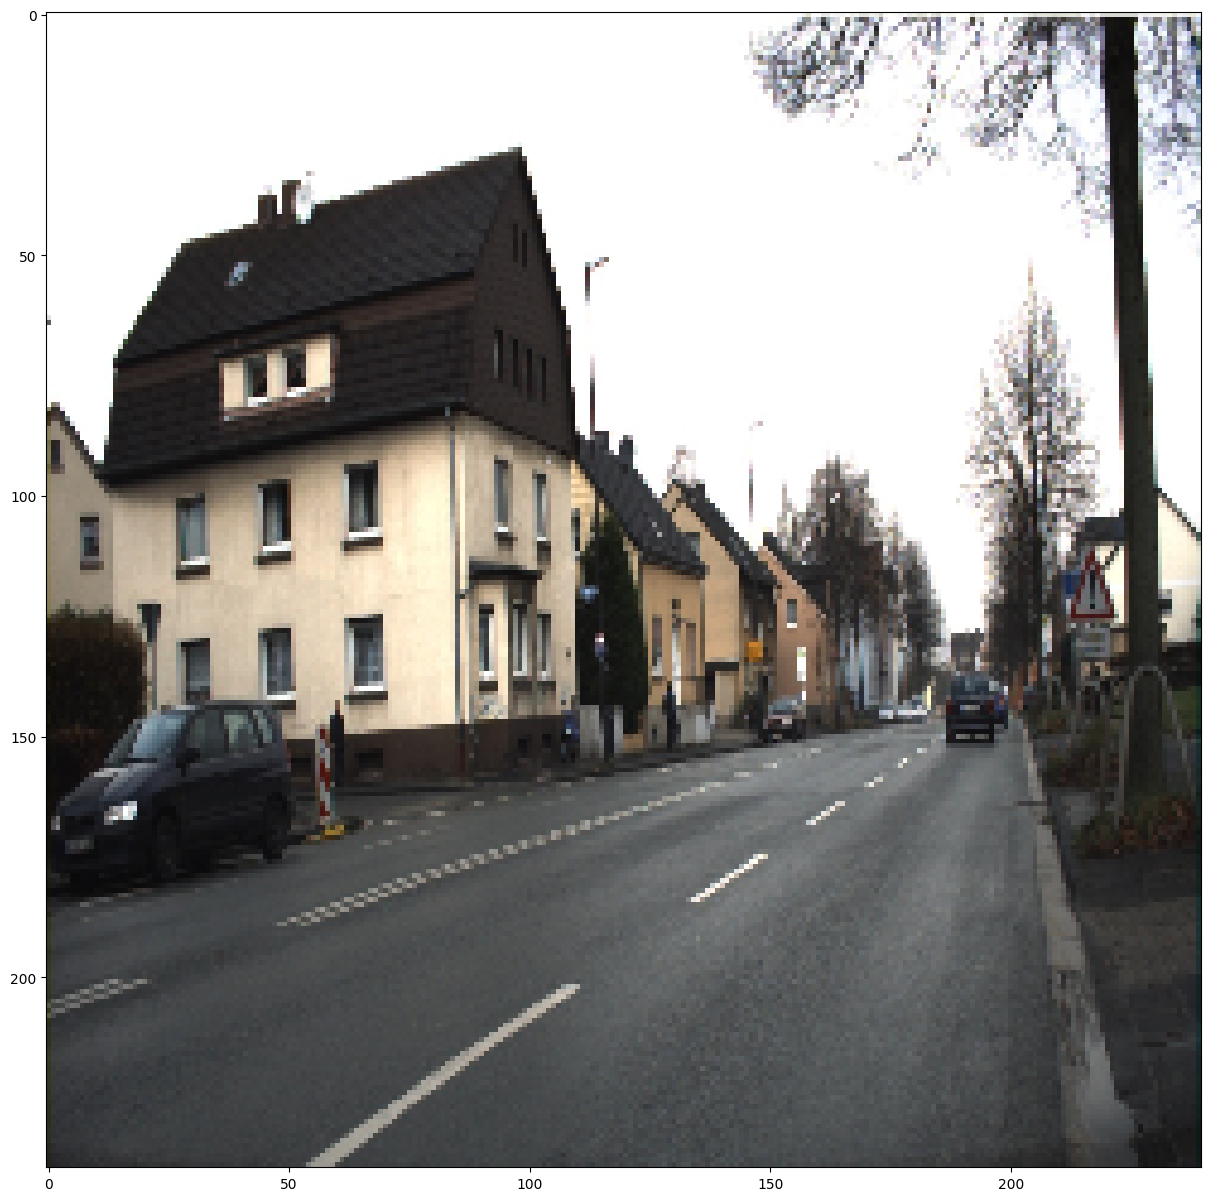

In [6]:
plt.figure(figsize=(15,15))
plt.imshow(image_list[8])
plt.show()

In [7]:
train_data = np.reshape(image_list, (len(image_list), -1))

In [8]:
train_data.shape

(741, 172800)

### Autoencoder Network

In [9]:
with nengo.Network(seed = 0) as auto_net:
    auto_net.config[nengo.Ensemble].max_rates = nengo.dists.Choice([200])
    auto_net.config[nengo.Ensemble].intercepts = nengo.dists.Choice([0])
    auto_net.config[nengo.Connection].synapse = None

    n_type = nengo.SpikingRectifiedLinear() 
    n_in = IMG_HEIGHT*IMG_WIDTH*3
    dim_hidden = 512

    input_node = nengo.Node(np.zeros(n_in))

    layer1 = nengo.Ensemble(dim_hidden, 1, neuron_type = n_type)
    nengo.Connection(input_node, layer1.neurons, transform=nengo_dl.dists.Glorot())

    layer2 = nengo.Ensemble(dim_hidden, 1, neuron_type = n_type)
    nengo.Connection(layer1.neurons, layer2.neurons, transform=nengo_dl.dists.Glorot())

    outp = nengo.Ensemble(n_in, 1, neuron_type=n_type)
    nengo.Connection(layer2.neurons, outp.neurons, transform=nengo_dl.dists.Glorot())

    p_c = nengo.Probe(outp.neurons)
    p_c_filt = nengo.Probe(outp.neurons, synapse=0.01, label="out_p_filt")

In [10]:
with nengo_dl.Simulator(network=auto_net, minibatch_size=MINIBATCH_SIZE) as sim:
  sim.predict(np.ones((MINIBATCH_SIZE, 1, n_in)));

|############         Building network (20%)                     | ETA: 0:00:00

/usr/local/lib/python3.10/dist-packages/nengo_dl/simulator.py:456: UserWarning: No GPU support detected. See https://www.nengo.ai/nengo-dl/installation.html#installing-tensorflow for instructions on setting up TensorFlow with GPU support.
  warnings.warn(


Build finished in 0:00:05                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:01                                               
|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

/usr/local/lib/python3.10/dist-packages/nengo_dl/simulator.py:1003: UserWarning: Running for one timestep, but the network contains synaptic filters (which will introduce at least a one-timestep delay); did you mean to set synapse=None?
  warnings.warn(


1/1 [==============================] - 3s 3s/step


### Train Model

In [11]:
for net_ens in auto_net.all_ensembles:
  net_ens.gain = nengo.dists.Choice([1])
  net_ens.bias = nengo.dists.Choice([0])

In [12]:
for conn in auto_net.all_connections:
  conn.synapse = None 

In [13]:
test_data = train_data

In [14]:
train_data.shape

(741, 172800)

In [15]:
train_data = train_data[:, None, :]

In [16]:
train_data.shape

(741, 1, 172800)

In [17]:
test_data = np.tile(test_data[:, None, :], (1, N_STEPS, 1))

In [18]:
test_data.shape

(741, 10, 172800)

In [19]:
train_data

array([[[255, 255, 255, ...,  23,  38,  35]],

       [[218, 218, 208, ...,  28,  45,  34]],

       [[234, 243, 246, ...,  14,  29,  35]],

       ...,

       [[221, 220, 215, ...,  24,  45,  46]],

       [[245, 252, 252, ...,  94, 120, 115]],

       [[241, 241, 231, ...,  23,  42,  40]]], dtype=uint8)

In [20]:
test_data

array([[[255, 255, 255, ...,  23,  38,  35],
        [255, 255, 255, ...,  23,  38,  35],
        [255, 255, 255, ...,  23,  38,  35],
        ...,
        [255, 255, 255, ...,  23,  38,  35],
        [255, 255, 255, ...,  23,  38,  35],
        [255, 255, 255, ...,  23,  38,  35]],

       [[218, 218, 208, ...,  28,  45,  34],
        [218, 218, 208, ...,  28,  45,  34],
        [218, 218, 208, ...,  28,  45,  34],
        ...,
        [218, 218, 208, ...,  28,  45,  34],
        [218, 218, 208, ...,  28,  45,  34],
        [218, 218, 208, ...,  28,  45,  34]],

       [[234, 243, 246, ...,  14,  29,  35],
        [234, 243, 246, ...,  14,  29,  35],
        [234, 243, 246, ...,  14,  29,  35],
        ...,
        [234, 243, 246, ...,  14,  29,  35],
        [234, 243, 246, ...,  14,  29,  35],
        [234, 243, 246, ...,  14,  29,  35]],

       ...,

       [[221, 220, 215, ...,  24,  45,  46],
        [221, 220, 215, ...,  24,  45,  46],
        [221, 220, 215, ...,  24,  45,  46

In [21]:
with nengo_dl.Simulator(auto_net, minibatch_size=MINIBATCH_SIZE) as sim:
  sim.compile(optimizer = tf.optimizers.RMSprop(1e-5), 
              loss = {p_c: tf.losses.mse,
                      p_c_filt: None}
             ) 
  sim.fit(train_data, train_data, epochs = 20)
  sim.freeze_params(auto_net)
  output = sim.predict(test_data[:MINIBATCH_SIZE])

|############         Building network (20%)                     | ETA: 0:00:00

/usr/local/lib/python3.10/dist-packages/nengo/builder/ensemble.py:112: NengoWarning: Specifying the gains and biases for <Ensemble (unlabeled) at 0x7fd093d2fc40> imposes a set of maximum firing rates and intercepts. Further specifying either max_rates or intercepts has no effect.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/nengo/builder/ensemble.py:112: NengoWarning: Specifying the gains and biases for <Ensemble (unlabeled) at 0x7fd093d83010> imposes a set of maximum firing rates and intercepts. Further specifying either max_rates or intercepts has no effect.
  warnings.warn(


|#####################Building network (40%)                     | ETA: 0:00:02

/usr/local/lib/python3.10/dist-packages/nengo/builder/ensemble.py:112: NengoWarning: Specifying the gains and biases for <Ensemble (unlabeled) at 0x7fd093d82770> imposes a set of maximum firing rates and intercepts. Further specifying either max_rates or intercepts has no effect.
  warnings.warn(


Build finished in 0:00:04                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:01                                               


/usr/local/lib/python3.10/dist-packages/nengo_dl/simulator.py:1892: UserWarning: Number of elements in input data (741) is not evenly divisible by Simulator.minibatch_size (32); input data will be truncated.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/nengo_dl/simulator.py:1736: UserWarning: Number of elements (1) in ['ndarray'] does not match number of Probes (2); consider using an explicit input dictionary in this case, so that the assignment of data to objects is unambiguous.
  warnings.warn(


Epoch 1/20
23/23 [==============================] - 93s 4s/step - loss: 14142.4092 - probe_loss: 14142.4092
Epoch 2/20
23/23 [==============================] - 79s 3s/step - loss: 11230.2617 - probe_loss: 11230.2617
Epoch 3/20
23/23 [==============================] - 77s 3s/step - loss: 10936.2090 - probe_loss: 10936.2090
Epoch 4/20
23/23 [==============================] - 84s 4s/step - loss: 10688.0840 - probe_loss: 10688.0840
Epoch 5/20
23/23 [==============================] - 79s 3s/step - loss: 10392.3779 - probe_loss: 10392.3779
Epoch 6/20
23/23 [==============================] - 81s 4s/step - loss: 10002.2441 - probe_loss: 10002.2441
Epoch 7/20
23/23 [==============================] - 79s 3s/step - loss: 9635.1240 - probe_loss: 9635.1240
Epoch 8/20
23/23 [==============================] - 80s 3s/step - loss: 9318.0801 - probe_loss: 9318.0801
Epoch 9/20
23/23 [==============================] - 81s 4s/step - loss: 9040.8008 - probe_loss: 9040.8008
Epoch 10/20
23/23 [===============

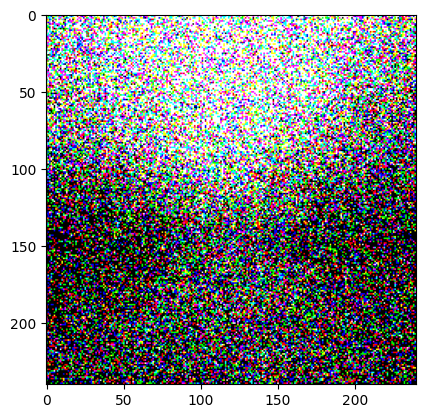

In [22]:
plt.figure()
plt.imshow(output[p_c_filt][0,4].reshape((240, 240, 3)))

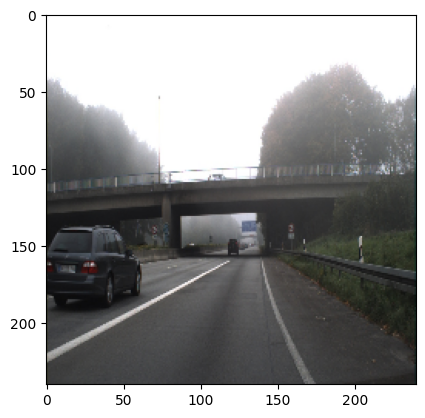

In [23]:
plt.imshow(test_data[0, 4].reshape(240, 240, 3))